# 05 — Analyse descriptive business par cluster

# Analyse descriptive business par segment client

Ce notebook vise à enrichir et expliquer les segments clients identifiés
lors de la phase de segmentation, en les reliant à des variables métier :

- catégories de produits
- modes de paiement
- localisation géographique

L’objectif est d’améliorer l’interprétation business et l’actionnabilité
des segments pour les équipes marketing et commerciales.


# Chargement des données

In [1]:
import pandas as pd
from pathlib import Path

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

PROJECT_DIR = Path.cwd().parent
INTERIM_DIR = PROJECT_DIR / "data" / "interim"
RAW_DIR = PROJECT_DIR / "data" / "raw"


In [2]:
# Table client avec clusters
client_clusters = pd.read_parquet(
    INTERIM_DIR / "client_features_with_clusters.parquet"
)

client_clusters.head()


,customer_unique_id,recency,frequency,monetary,avg_basket,total_items,avg_delivery_delay,avg_review_score,nb_categories,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,141.90,1,6.0,5.0,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,27.19,1,3.0,4.0,1,0
2,0000f46a3911fa3c0805444483337064,536,1,86.22,86.22,1,25.0,3.0,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,43.62,1,20.0,4.0,1,0
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,196.89,1,13.0,5.0,1,0


In [3]:
# Chargement des données nécessaires
orders = pd.read_csv(RAW_DIR / "olist_orders_dataset.csv")
order_items = pd.read_csv(RAW_DIR / "olist_order_items_dataset.csv")
products = pd.read_csv(RAW_DIR / "olist_products_dataset.csv")

orders.head(), order_items.head(), products.head()


(                           order_id                       customer_id order_status order_purchase_timestamp  \
 0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
 1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef    delivered      2018-07-24 20:41:37   
 2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089    delivered      2018-08-08 08:38:49   
 3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82    delivered      2017-11-18 19:28:06   
 4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c    delivered      2018-02-13 21:18:39   
 
      order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date  
 0  2017-10-02 11:07:15          2017-10-04 19:55:00           2017-10-10 21:25:13           2017-10-18 00:00:00  
 1  2018-07-26 03:24:27          2018-07-26 14:31:00           2018-08-07 15:27:45           201

## Nettoyage et sauvegarde : orders_clean

In [5]:
customers = pd.read_csv(RAW_DIR / "olist_customers_dataset.csv")
customers.shape


(99441, 5)

In [9]:
orders_clean = (
    orders.merge(
        customers[["customer_id", "customer_unique_id"]],
        on="customer_id",
        how="left"
    )
    [["order_id", "customer_id", "customer_unique_id", "order_status"]]
    .copy()
)

orders_clean = orders_clean[orders_clean["order_status"] == "delivered"].copy()

orders_clean.shape


(96478, 4)

In [10]:
orders_clean.to_parquet(
    INTERIM_DIR / "orders_clean.parquet",
    index=False
)


## Nettoyage et sauvegarde : order_items_clean

In [11]:
order_items_clean = order_items[[
    "order_id",
    "product_id",
    "price",
    "freight_value"
]].copy()


In [12]:
order_items_clean.isna().mean()


order_id         0.0
product_id       0.0
price            0.0
freight_value    0.0
dtype: float64

In [13]:
order_items_clean.to_parquet(
    INTERIM_DIR / "order_items_clean.parquet",
    index=False
)


## Nettoyage et sauvegarde : products_clean

In [14]:
products_clean = products[[
    "product_id",
    "product_category_name"
]].copy()

products_clean["product_category_name"] = (
    products_clean["product_category_name"]
    .fillna("unknown")
)


In [15]:
products_clean["product_category_name"].value_counts().head()


product_category_name
cama_mesa_banho          3029
esporte_lazer            2867
moveis_decoracao         2657
beleza_saude             2444
utilidades_domesticas    2335
Name: count, dtype: int64

In [16]:
products_clean.to_parquet(
    INTERIM_DIR / "products_clean.parquet",
    index=False
)


# Chargement des datasets clean

In [18]:
import pandas as pd
from pathlib import Path

PROJECT_DIR = Path.cwd().parent
INTERIM_DIR = PROJECT_DIR / "data" / "interim"

orders_clean = pd.read_parquet(INTERIM_DIR / "orders_clean.parquet")
order_items_clean = pd.read_parquet(INTERIM_DIR / "order_items_clean.parquet")
products_clean = pd.read_parquet(INTERIM_DIR / "products_clean.parquet")
client_clusters = pd.read_parquet(
    INTERIM_DIR / "client_features_with_clusters.parquet"
)

orders_clean.shape, order_items_clean.shape, products_clean.shape, client_clusters.shape


((96478, 4), (112650, 4), (32951, 2), (93358, 10))

# Construction du pipeline analytique

- On se demande dans chaque segment client, quelles catégories de produits sont les plus achetées ?

In [19]:
# relier commande et clusters
orders_clusters = orders_clean.merge(
    client_clusters[["customer_unique_id", "cluster"]],
    on="customer_unique_id",
    how="left"
)


In [20]:
# relier commande et produits
orders_items = orders_clusters.merge(
    order_items_clean[["order_id", "product_id"]],
    on="order_id",
    how="left"
)


In [21]:
# relier produits et categories
orders_products = orders_items.merge(
    products_clean,
    on="product_id",
    how="left"
)

orders_products.head()


,order_id,customer_id,customer_unique_id,order_status,cluster,product_id,product_category_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,0,87285b34884572647811a353c7ac498a,utilidades_domesticas
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,delivered,0,595fac2a385ac33a80bd5114aec74eb8,perfumaria
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,delivered,0,aa4383b373c6aca5d8797843e5594415,automotivo
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,delivered,0,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,delivered,0,65266b2da20d04dbe00c5c2d3bb7859e,papelaria


## Analyse des categories par cluster

In [22]:
category_cluster_counts = (
    orders_products
    .groupby(["cluster", "product_category_name"])
    .size()
    .reset_index(name="nb_items")
)


In [23]:
# Top 10 categories par cluster
top_categories_per_cluster = (
    category_cluster_counts
    .sort_values(["cluster", "nb_items"], ascending=[True, False])
    .groupby("cluster")
    .head(10)
)

top_categories_per_cluster


,cluster,product_category_name,nb_items
13,0,cama_mesa_banho,7725
11,0,beleza_saude,6875
32,0,esporte_lazer,6463
54,0,moveis_decoracao,5659
44,0,informatica_acessorios,5190
73,0,utilidades_domesticas,5083
66,0,relogios_presentes,3867
70,0,telefonia,3294
12,0,brinquedos,3092
40,0,ferramentas_jardim,3011


### Part relative des catégories

In [24]:
category_cluster_share = (
    category_cluster_counts
    .groupby("cluster", group_keys=False)
    .apply(lambda x: x.assign(share=x["nb_items"] / x["nb_items"].sum()))
)


C:\Users\darry\AppData\Local\Temp\ipykernel_56000\2347087432.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(share=x["nb_items"] / x["nb_items"].sum()))


In [25]:
# top 5 categories
category_cluster_share.sort_values(
    ["cluster", "share"], ascending=[True, False]
).groupby("cluster").head(5)


,cluster,product_category_name,nb_items,share
13,0,cama_mesa_banho,7725,0.097639
11,0,beleza_saude,6875,0.086896
32,0,esporte_lazer,6463,0.081688
54,0,moveis_decoracao,5659,0.071526
44,0,informatica_acessorios,5190,0.065598
101,1,informatica_acessorios,151,0.120032
112,1,pcs,127,0.100954
77,1,automotivo,94,0.074722
115,1,relogios_presentes,92,0.073132
80,1,beleza_saude,91,0.072337


# Analyse des modes de paiement par cluster

In [26]:
payments = pd.read_csv(RAW_DIR / "olist_order_payments_dataset.csv")
payments.shape


(103886, 5)

In [27]:
# Création de payments_clean
payments_clean = payments[[
    "order_id",
    "payment_type",
    "payment_installments",
    "payment_value"
]].copy()


In [28]:
payments_clean.isna().mean()


order_id                0.0
payment_type            0.0
payment_installments    0.0
payment_value           0.0
dtype: float64

In [29]:
payments_clean.to_parquet(
    INTERIM_DIR / "payments_clean.parquet",
    index=False
)


### Construction du lien : cluster → commande → paiement

In [30]:
orders_clusters = orders_clean.merge(
    client_clusters[["customer_unique_id", "cluster"]],
    on="customer_unique_id",
    how="left"
)


In [31]:
orders_payments = orders_clusters.merge(
    payments_clean,
    on="order_id",
    how="left"
)

orders_payments.head()


,order_id,customer_id,customer_unique_id,order_status,cluster,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,delivered,0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,delivered,0,credit_card,3.0,179.12


### Analyse mode de paiment par cluster

In [32]:
payment_cluster_counts = (
    orders_payments
    .groupby(["cluster", "payment_type"])
    .size()
    .reset_index(name="nb_payments")
)


In [33]:
# part relative part cluster
payment_cluster_share = (
    payment_cluster_counts
    .groupby("cluster", group_keys=False)
    .apply(lambda x: x.assign(share=x["nb_payments"] / x["nb_payments"].sum()))
)


C:\Users\darry\AppData\Local\Temp\ipykernel_56000\569034478.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(share=x["nb_payments"] / x["nb_payments"].sum()))


In [34]:
# top modes de paiement par cluster
payment_cluster_share.sort_values(
    ["cluster", "share"], ascending=[True, False]
).groupby("cluster").head(5)


,cluster,payment_type,nb_payments,share
1,0,credit_card,55792,0.736635
0,0,boleto,14597,0.192728
3,0,voucher,4170,0.055058
2,0,debit_card,1180,0.015580
5,1,credit_card,660,0.788530
4,1,boleto,135,0.161290
7,1,voucher,31,0.037037
6,1,debit_card,11,0.013142
9,2,credit_card,11924,0.729922
8,2,boleto,3226,0.197478


In [35]:
# paiement en plusieurs fois
installments_by_cluster = (
    orders_payments
    .groupby("cluster")["payment_installments"]
    .mean()
    .round(2)
)

installments_by_cluster


cluster
0    2.58
1    6.30
2    2.86
3    5.13
Name: payment_installments, dtype: float64

### Analyse des modes de paiement par segment

L’analyse des modes de paiement met en évidence des différences de
comportement entre les segments clients. Certains segments, notamment
les clients à forte valeur, présentent une utilisation plus marquée des
paiements fractionnés, suggérant des leviers d’optimisation commerciale
adaptés par segment.



# Analyse régionale par cluster

In [ ]:
import pandas as pd
from pathlib import Path

PROJECT_DIR = Path.cwd().parent
RAW_DIR = PROJECT_DIR / "data" / "raw"
INTERIM_DIR = PROJECT_DIR / "data" / "interim"

customers = pd.read_csv(RAW_DIR / "olist_customers_dataset.csv")
orders_clean = pd.read_parquet(INTERIM_DIR / "orders_clean.parquet")
client_clusters = pd.read_parquet(
    INTERIM_DIR / "client_features_with_clusters.parquet"
)

customers.shape, orders_clean.shape, client_clusters.shape


## Construction du lien : cluster → client → région

In [36]:
# cluster et clients
clients_regions = client_clusters.merge(
    customers[["customer_unique_id", "customer_state"]],
    on="customer_unique_id",
    how="left"
)

clients_regions.head()


,customer_unique_id,recency,frequency,monetary,avg_basket,total_items,avg_delivery_delay,avg_review_score,nb_categories,cluster,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,141.90,1,6.0,5.0,1,0,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,27.19,1,3.0,4.0,1,0,SP
2,0000f46a3911fa3c0805444483337064,536,1,86.22,86.22,1,25.0,3.0,1,2,SC
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,43.62,1,20.0,4.0,1,0,PA
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,196.89,1,13.0,5.0,1,0,SP


In [37]:
# nettoyage 
clients_regions["customer_state"] = (
    clients_regions["customer_state"]
    .fillna("unknown")
)


##  repartition par cluster

In [38]:

region_cluster_counts = (
    clients_regions
    .groupby(["cluster", "customer_state"])
    .size()
    .reset_index(name="nb_clients")
)


In [39]:
# part relative par cluster
region_cluster_share = (
    region_cluster_counts
    .groupby("cluster", group_keys=False)
    .apply(lambda x: x.assign(share=x["nb_clients"] / x["nb_clients"].sum()))
)


C:\Users\darry\AppData\Local\Temp\ipykernel_56000\2314875161.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(share=x["nb_clients"] / x["nb_clients"].sum()))


In [40]:
# top 5 regions
region_cluster_share.sort_values(
    ["cluster", "share"], ascending=[True, False]
).groupby("cluster").head(5)


,cluster,customer_state,nb_clients,share
25,0,SP,32647,0.449120
10,0,MG,8668,0.119244
18,0,RJ,8549,0.117607
22,0,RS,4000,0.055027
17,0,PR,3848,0.052936
51,1,SP,243,0.304893
45,1,RJ,113,0.141782
37,1,MG,86,0.107905
44,1,PR,46,0.057716
48,1,RS,46,0.057716


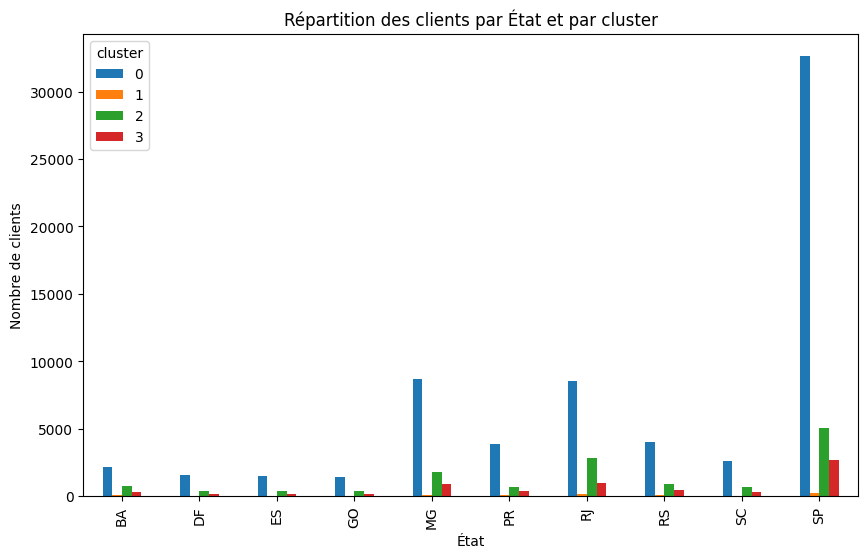

In [41]:
import matplotlib.pyplot as plt

top_states = (
    region_cluster_counts
    .groupby("customer_state")["nb_clients"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

plot_df = region_cluster_counts[
    region_cluster_counts["customer_state"].isin(top_states)
]

plot_df.pivot(
    index="customer_state",
    columns="cluster",
    values="nb_clients"
).plot(kind="bar", figsize=(10,6))

plt.title("Répartition des clients par État et par cluster")
plt.ylabel("Nombre de clients")
plt.xlabel("État")
plt.show()


### Analyse régionale par segment

L’analyse régionale des segments clients met en évidence des différences
de distribution géographique selon les profils. Certaines régions
concentrent des segments spécifiques, suggérant des enjeux logistiques
et des opportunités de ciblage marketing régionalisé.
